# Sales Analysis with SQL

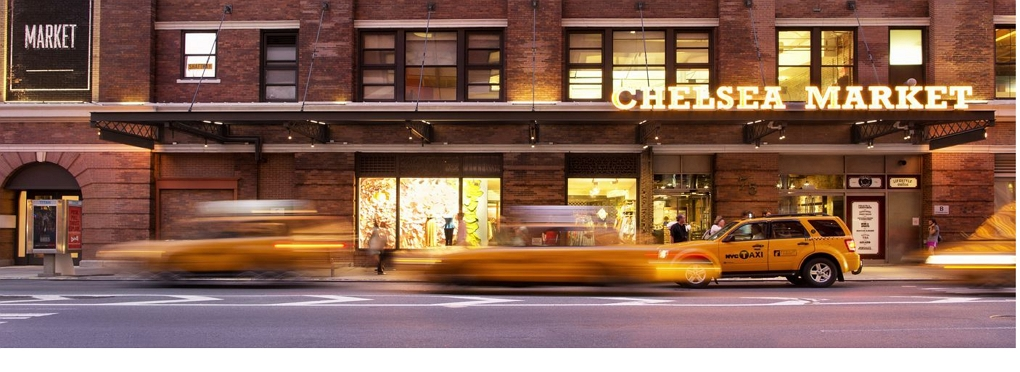

Hello all! This is a portfolio project showcasing SQL techniques. In this project, I will define some analytical tasks for an e-commerce dataset and provide the corresponding solution query. I will use SQLite to set up the database and present all the queries. Here is the agenda for the project：


1. About Dataset
2. Analytical Tasks
3. Set Up Environment
4. Get Started
5. Summary



# 1. About Dataset

This is a [Brazillian e-commerce dataset from Kaggle](https://www.kaggle.com/olistbr/brazilian-ecommerce?select=olist_orders_dataset.csv). The entire dataset is consists of 100k orders from 2016/9 to 2018/10, including 9 tables with different information, such as transaction records, product categories, and so on. All tables are related by specific id, thus we can easily look up information from one to another. In this project, I will use tables listed below :


* olist_orders_dataset
* olist_order_items_dataset
* olist_products_dataset
* product_category_name_translation
* olist_customers_dataset

# 2. Analytical Tasks

As below, I designed 5 tasks to showcase different techniques. The main SQL function used is listed at the end.


1. Find out the top 5 product categories with highest sales ——————— join
2. Find out the top 3 cities with highest sales in category 「health_beauty」 ——————— CTE
3. Group all orders in 2017 into months, and label them by sales performance ——————— window function / case
4. Classify the product categories into 3 different groups by average weight ——————— case
5. Find out the products that are most frequently bought together by customers ——————— CTE / self join


# 3. Set Up Environment

### 3.1. Set up database and import dataset

In [1]:
import pandas as pd
import sqlite3
con = sqlite3.connect('project.db')

In [3]:
order = pd.read_csv('./Brazilian E-Commerce Public Dataset by Olist/olist_orders_dataset.csv')
item = pd.read_csv('./Brazilian E-Commerce Public Dataset by Olist/olist_order_items_dataset.csv')
product = pd.read_csv('./Brazilian E-Commerce Public Dataset by Olist/olist_products_dataset.csv')
product_tr = pd.read_csv('./Brazilian E-Commerce Public Dataset by Olist/product_category_name_translation.csv')
customer = pd.read_csv('./Brazilian E-Commerce Public Dataset by Olist/olist_customers_dataset.csv')

In [4]:
order.to_sql('order_', con)
item.to_sql('item', con)
product.to_sql('product', con)
product_tr.to_sql('product_tr', con)
customer.to_sql('customer', con)

In [2]:
%load_ext sql
%sql sqlite:///project1.db

### 3.2. Data preparation

In order to simplify the query, I created two temporary tables for later work :  (1) temp_product  (2) temp_order

### temp_product

The original "product table" only provides Brazilian product name, therefore, I joined it with "translation table" to improve the readability. 

In [3]:
%%sql

create temp table temp_product (
product_category_name varchar(50),
product_category_name_english varchar(50),
product_id varchar(50),
product_weight_g smallint)

 * sqlite:///project1.db
Done.


[]

In [4]:
%%sql

insert into temp_product
select product.product_category_name, product_tr.product_category_name_english, product.product_id, product.product_weight_g
from product 
join product_tr
on product.product_category_name = product_tr.product_category_name

 * sqlite:///project1.db
32328 rows affected.


[]

In [25]:
%%sql

select * from temp_product
limit 3

 * sqlite:///project1.db
Done.


product_category_name,product_category_name_english,product_id,product_weight_g
perfumaria,perfumery,1e9e8ef04dbcff4541ed26657ea517e5,225
artes,art,3aa071139cb16b67ca9e5dea641aaa2f,1000
esporte_lazer,sports_leisure,96bd76ec8810374ed1b65e291975717f,154


### temp_order

temp_order is joined by "order table" & "order item table". "order table" provides general transaction data (such as purchase time), while "order item table" provides the item list for each order.

In [5]:
%%sql

create temp table temp_order(
order_id varchar(50),
product_id varchar(50),
order_item_id smallint,
price smallint,
order_purchase_timestamp timestamp,
seller_id varchar(50),
customer_id varchar(50))

 * sqlite:///project1.db
Done.


[]

In [6]:
%%sql

insert into temp_order
select item.order_id, item.product_id, item.order_item_id, item.price, order_.order_purchase_timestamp, item.seller_id, order_.customer_id 
from item
join order_
on item.order_id = order_.order_id
where order_.order_status = 'delivered'

 * sqlite:///project1.db
110197 rows affected.


[]

In [24]:
%%sql

select * from temp_order
limit 3

 * sqlite:///project1.db
Done.


order_id,product_id,order_item_id,price,order_purchase_timestamp,seller_id,customer_id
e481f51cbdc54678b7cc49136f2d6af7,87285b34884572647811a353c7ac498a,1,29.99,2017-10-02 10:56:33,3504c0cb71d7fa48d967e0e4c94d59d9,9ef432eb6251297304e76186b10a928d
53cdb2fc8bc7dce0b6741e2150273451,595fac2a385ac33a80bd5114aec74eb8,1,118.7,2018-07-24 20:41:37,289cdb325fb7e7f891c38608bf9e0962,b0830fb4747a6c6d20dea0b8c802d7ef
47770eb9100c2d0c44946d9cf07ec65d,aa4383b373c6aca5d8797843e5594415,1,159.9,2018-08-08 08:38:49,4869f7a5dfa277a7dca6462dcf3b52b2,41ce2a54c0b03bf3443c3d931a367089


※ Column " order_item_id " indicates the quantity of the product in that order.

# 4. Get Started

### 4.1. Find out the top 5 product categories with highest sales

To solve the task, we need 「product category list」 from table 「temp_product」 & 「total sales」from table 「temp_order」. We will first combine the two tables then extract the information we need. Below is my thinking process :

1. Join table 「temp_product」 with 「temp_order」
2. Extract 「product category」 and 「sum of sales」
3. Order 「product category」 by 「sum of sales」 descendingly
4. Pick top 5 values

In [22]:
%%sql


select tempp.product_category_name_english as 'Top 5 product categories', 
round(sum(tempo.order_item_id * tempo.price),2) as 'Sum of sales'

from temp_order tempo
join temp_product tempp
on tempo.product_id = tempp.product_id

group by 1
order by 2 desc
limit 5

 * sqlite:///project1.db
Done.


Top 5 product categories,Sum of sales
health_beauty,1318521.28
watches_gifts,1220583.92
bed_bath_table,1213767.78
computers_accessories,1108189.67
sports_leisure,1047506.42


### 4.2. Find out the top 3 cities with highest sales in category 「health_beauty」

Similar to the previous task, but this time we need 「product category list」, 「total sales」, and 「customer locations (city)」, which means we have to combine 3 different tables. Thus, I created a CTE to avoid the query from being too complicated. Below is my thinking process :

1. Create a CTE 「health_beauty_orders」 to extract 「health_beauty」 transactions
2. Join the CTE with 「customer table」
3. Extract 「city list」 and 「sum of sales」
4. Sort the 「city list」 by 「sum of sales」 descendingly
5. Pick the top 3 values

In [1]:
%%sql

with health_beauty_orders as

(select tempo.*
from temp_order tempo
join temp_product tempp
on tempo.product_id = tempp.product_id
where tempp.product_category_name_english = 'health_beauty')

select cus.customer_city as 'Top 3 cities', 
round(sum(heal.order_item_id * heal.price),2) as "Sum of sales" 
 
from health_beauty_orders heal 
join customer cus
on heal.customer_id = cus.customer_id

group by 1
order by 2 desc
limit 3

UsageError: Cell magic `%%sql` not found.


### 4.3. Group all orders in 2017 into months, and label them by sales performance


$\;\;\;\;\;\;$ ※ If the sales is above 2017 average, label it as 「Above Average!」, else 「Below Average」  
$\;\;\;\;\;\;$ ※ Show the average sales in a new column 

To show the monthly sales with average simultaneously, we need to use the window function. Below is my thinking process :   
  
1. Group the orders into months
2. Filter the orders with 「year」 equal to 2017 
3. Extract 「month」 & 「total sales」 from the table
4. Use the window function to create a column of average monthly sales
5. Use the case function to compare monthly sales with average, then give it a label

In [21]:
%%sql

select sub.*, 
round(avg(sub.'Monthly Sales') over (),2) as 'Avg. Monthly Sales',
case when sub.'Monthly Sales' > avg(sub.'Monthly Sales') over () then 'Above Average!'
else 'Below Average' end as 'Sales Perfomance'

from 
 (select strftime('%Y-%m', order_purchase_timestamp) as 'Month', 
 round(sum(order_item_id * price),2) as 'Monthly Sales'
 from temp_order
 group by 1) sub

where substr(sub.Month,1,4) = '2017'
order by sub.Month

 * sqlite:///project1.db
Done.


Month,Monthly Sales,Avg. Monthly Sales,Sales Perfomance
2017-01,132971.99,563454.32,Below Average
2017-02,255393.44,563454.32,Below Average
2017-03,395587.6,563454.32,Below Average
2017-04,367298.52,563454.32,Below Average
2017-05,544141.44,563454.32,Below Average
2017-06,459780.59,563454.32,Below Average
2017-07,540481.85,563454.32,Below Average
2017-08,634329.66,563454.32,Above Average!
2017-09,736789.34,563454.32,Above Average!
2017-10,748498.94,563454.32,Above Average!


### 4.4. Classify the product categories into 3 different groups by average weight


$\;\;\;\;\;\;$ ※ Heavy$\;\;$：$\;\;$weight >= 5000g   
$\;\;\;\;\;\;$ ※ Medium：$\;\;$500g >= weight < 5000g  
$\;\;\;\;\;\;$ ※ Light$\;\;\;\;$：$\;\;$weight < 500g

Here we use the case function to classify the product categories. Below is the thinking process :

1. Extract 「product category」 & 「average weight」 from table 「temp_product」
2. Use the case function to classify the categories
3. Order 「product category」 by weight group : Heavy → Medium → Light

In [31]:
%%sql

select product_category_name_english as 'Product Category', 
round(avg(product_weight_g),2) as 'Avg. Weight', 
case when avg(product_weight_g) >= 5000 then 'Heavy'
     when avg(product_weight_g) >= 500 then 'Medium'
     else 'Light' end as Weight_Group
        
from temp_product

group by 1
order by Weight_Group = 'Heavy' desc, 
         Weight_Group = 'Medium' desc,
         Weight_Group = 'Light' desc

 * sqlite:///project1.db
Done.


Product Category,Avg. Weight,Weight_Group
agro_industry_and_commerce,5263.41,Heavy
computers,7995.33,Heavy
furniture_bedroom,9997.22,Heavy
furniture_living_room,8934.85,Heavy
furniture_mattress_and_upholstery,13190.0,Heavy
home_appliances_2,9913.33,Heavy
industry_commerce_and_business,5929.19,Heavy
kitchen_dining_laundry_garden_furniture,11598.56,Heavy
office_furniture,12740.87,Heavy
air_conditioning,4459.96,Medium


### 4.5. Find out the products that are most frequently bought together by customers

To solve this task, we need to put the products into 2 in a set (row), then find out the most frequent set among the orders. The original table is shown below, as you can see, the products are listed row by row, not 2 in a row as preferred, so here we will use self join to modify the table structure.

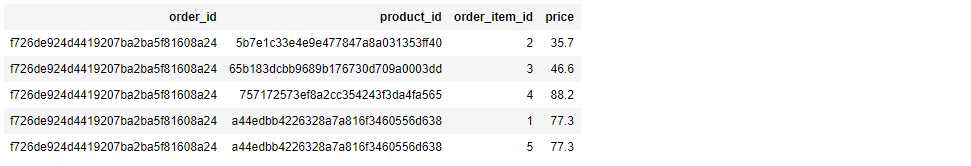

$\;\;$
**Below is my thinking process :**

1. Find out the distinct products in each order (there might be duplicates in one order) and put it into a CTE
2. Use self join to modify the CTE (put 2 products into a row)
3. Count the numbers of each set
4. Sort the sets by counts descendingly 
5. Pick the first value

In [74]:
%%sql

with pro_distinct as

(select order_id, product_id
from temp_order
group by 1,2)

select 
p1.product_id, 
p2.product_id, 
count(*) as Counts

from pro_distinct p1
join pro_distinct p2
on p1.order_id = p2.order_id 
and p1.product_id != p2.product_id

group by 1, 2
order by 3 desc
limit 10

 * sqlite:///project1.db
Done.


product_id,product_id_1,Counts
36f60d45225e60c7da4558b070ce4b60,e53e557d5a159f5aa2c5e995dfdf244b,34
e53e557d5a159f5aa2c5e995dfdf244b,36f60d45225e60c7da4558b070ce4b60,34
35afc973633aaeb6b877ff57b2793310,99a4788cb24856965c36a24e339b6058,29
99a4788cb24856965c36a24e339b6058,35afc973633aaeb6b877ff57b2793310,29
4fcb3d9a5f4871e8362dfedbdb02b064,f4f67ccaece962d013a4e1d7dc3a61f7,17
f4f67ccaece962d013a4e1d7dc3a61f7,4fcb3d9a5f4871e8362dfedbdb02b064,17
36f60d45225e60c7da4558b070ce4b60,3f14d740544f37ece8a9e7bc8349797e,12
3f14d740544f37ece8a9e7bc8349797e,36f60d45225e60c7da4558b070ce4b60,12
389d119b48cf3043d311335e499d9c6b,422879e10f46682990de24d770e7f83d,11
422879e10f46682990de24d770e7f83d,389d119b48cf3043d311335e499d9c6b,11


**Result explanation :**

Product 「36f60d45225e60c7da4558b070ce4b60」 & 「e53e557d5a159f5aa2c5e995dfdf244b」 are most frequently bought together by customers, they appeared 34 times among the dataset.

# 5. Summary

Alright, this is the end, thank you so much for being with me. All in all, here are our observations :  

#### 1. Top 5 product categories with the highest sales are :

$\;\;\;$ 1. health_beauty $\;\;$ 2. watches_gifts $\;\;$ 3. bed_bath_table $\;\;$ 4. computers_accessories $\;\;$ 5. sports_leisure	

#### 2. Top 3 cities with the highest sales in category 「health_beauty」 are :

$\;\;\;$ 1. Sao Paulo $\;\;$ 2. Rio de Janeiro $\;\;$ 3. Belo Horizonte

#### 3. Monthly sales from 2017/8 ~ 2017/12 are higher than 2017 average

#### 4. Most product categories' average weight lies in 500 ~ 5,000g  

#### 5. The most frequently bought product set appeared 34 times among the data, and belongs to category「Computer Accessories」